# Direct transfer of BrainLM on development dataset

The development dataset and the prediction workflow is adopted from MAIN educational workshop on Nilearn.

This dataset is an easy target as there's a known bias: the coverage of the brain scan betwenn kids and adults are different in the cerebellum.
When using an atlas that covers the cerebellum to extract features, the classification task should easily overfit.

Since BrainLM uses an atlas that covers cerebellum, this is a good dataset to test if the features got through direct transfer is anything useful.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from datasets import load_from_disk
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

In [2]:
def pca_svc(C, x, y):
    """
    Extract the top 5 principal components and use a SVM to predict categorical
    label, 3 fold CV.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, stratify=y, random_state=42
    )
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=5)), 
        ('svc', SVC(C=C, class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=3)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv)
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv)

    overall_acc = accuracy_score(y_pred=y_pred, y_true=y_train)
    overall_cr = classification_report(y_pred=y_pred, y_true=y_train)
    overall_cm = confusion_matrix(y_pred=y_pred, y_true=y_train)
    print('Overall Accuracy:', overall_acc)
    print(overall_cr)

    thresh = overall_cm.max() / 2
    cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
    sns.heatmap(cmdf, cmap='copper', annot=cmdf, vmax=thresh)
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    

## Prediction on adult vs child with giga connectome data processing workflow

Since the atlas covers cerebellum, this should overfit very easily

Overall Accuracy: 0.8793103448275862
              precision    recall  f1-score   support

       adult       0.72      0.72      0.72        25
       child       0.92      0.92      0.92        91

    accuracy                           0.88       116
   macro avg       0.82      0.82      0.82       116
weighted avg       0.88      0.88      0.88       116

Overall Accuracy: 0.41379310344827586
              precision    recall  f1-score   support

       adult       0.24      0.80      0.37        25
       child       0.85      0.31      0.45        91

    accuracy                           0.41       116
   macro avg       0.54      0.55      0.41       116
weighted avg       0.72      0.41      0.43       116

Overall Accuracy: 0.7327586206896551
              precision    recall  f1-score   support

       adult       0.42      0.64      0.51        25
       child       0.88      0.76      0.82        91

    accuracy                           0.73       116
   macro avg    

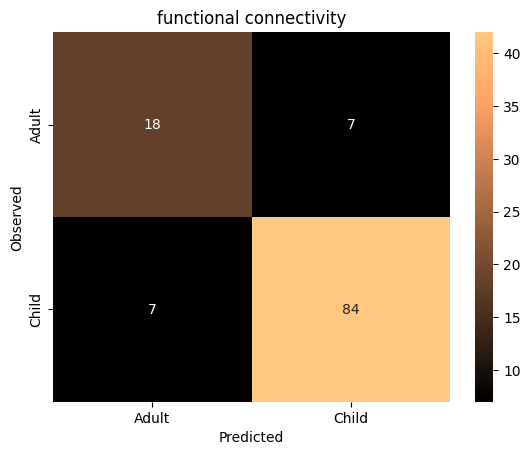

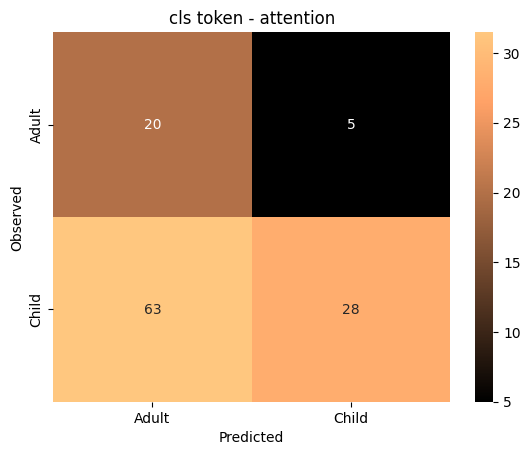

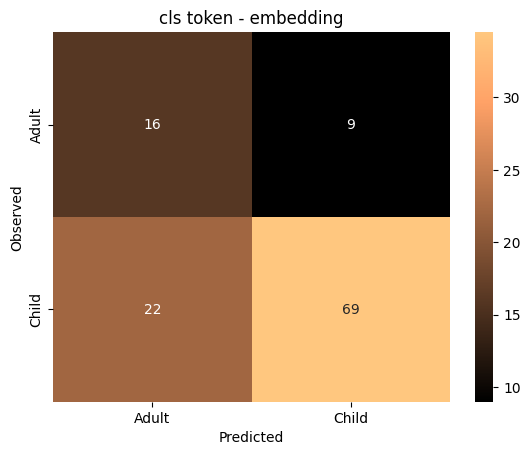

In [3]:
features = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_111M.arrow")
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)

plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc, y_ageclass)
plt.figure()
plt.title("cls token - attention")
pca_svc(1, cls_token, y_ageclass)
plt.figure()
plt.title("cls token - embedding")
pca_svc(1, np.array(features['embedding']).squeeze(), y_ageclass)

Overall Accuracy: 0.9051724137931034
              precision    recall  f1-score   support

       adult       0.75      0.84      0.79        25
       child       0.95      0.92      0.94        91

    accuracy                           0.91       116
   macro avg       0.85      0.88      0.87       116
weighted avg       0.91      0.91      0.91       116

Overall Accuracy: 0.3448275862068966
              precision    recall  f1-score   support

       adult       0.24      0.92      0.38        25
       child       0.89      0.19      0.31        91

    accuracy                           0.34       116
   macro avg       0.57      0.55      0.34       116
weighted avg       0.75      0.34      0.32       116

Overall Accuracy: 0.8620689655172413
              precision    recall  f1-score   support

       adult       0.71      0.60      0.65        25
       child       0.89      0.93      0.91        91

    accuracy                           0.86       116
   macro avg     

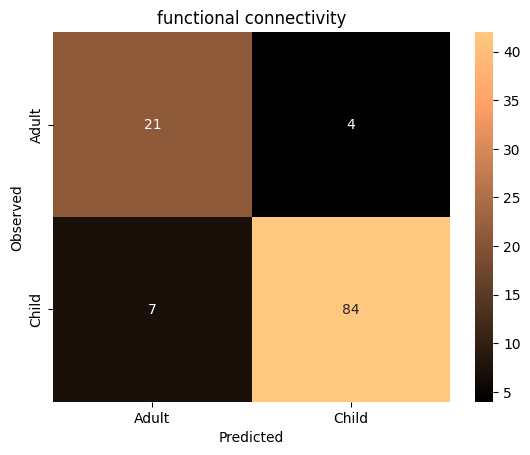

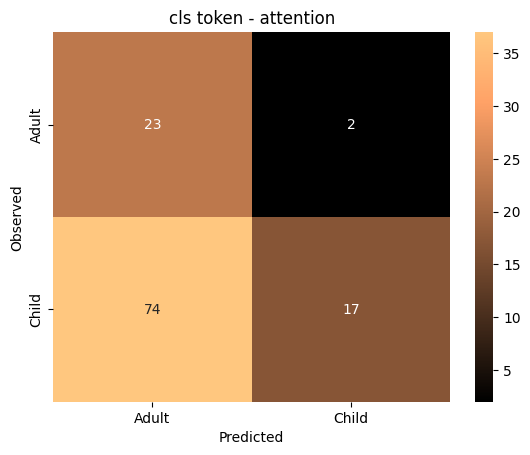

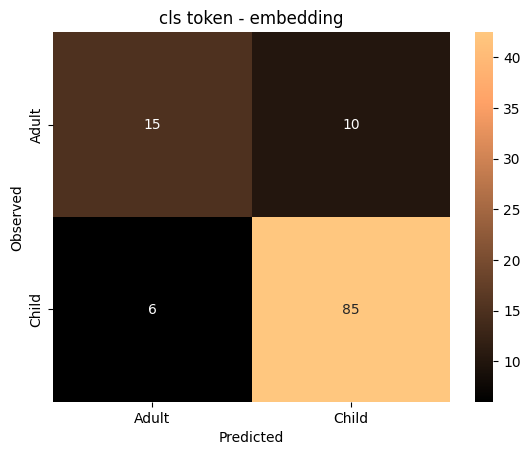

In [4]:
features = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_650M.arrow")
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)

plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc, y_ageclass)
plt.figure()
plt.title("cls token - attention")
pca_svc(1, cls_token, y_ageclass)
plt.figure()
plt.title("cls token - embedding")
pca_svc(1, np.array(features['embedding']).squeeze(), y_ageclass)

## Prediction on adult vs child with brainlm data processing workflow

Since the atlas covers cerebellum, this should overfit very easilyon child vs adult

Overall Accuracy: 0.9137931034482759
              precision    recall  f1-score   support

       adult       0.80      0.80      0.80        25
       child       0.95      0.95      0.95        91

    accuracy                           0.91       116
   macro avg       0.87      0.87      0.87       116
weighted avg       0.91      0.91      0.91       116

Overall Accuracy: 0.6896551724137931
              precision    recall  f1-score   support

       adult       0.21      0.16      0.18        25
       child       0.78      0.84      0.81        91

    accuracy                           0.69       116
   macro avg       0.50      0.50      0.50       116
weighted avg       0.66      0.69      0.67       116

Overall Accuracy: 0.4396551724137931
              precision    recall  f1-score   support

       adult       0.14      0.32      0.20        25
       child       0.72      0.47      0.57        91

    accuracy                           0.44       116
   macro avg     

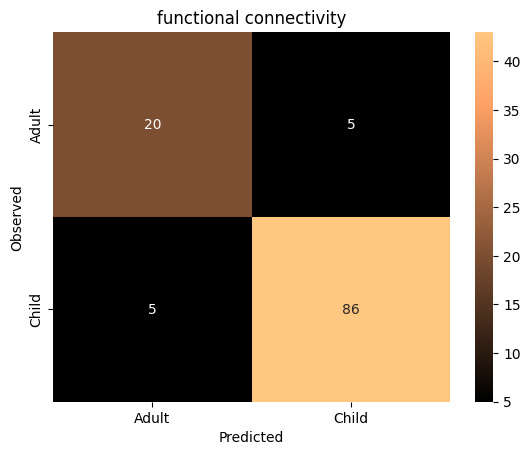

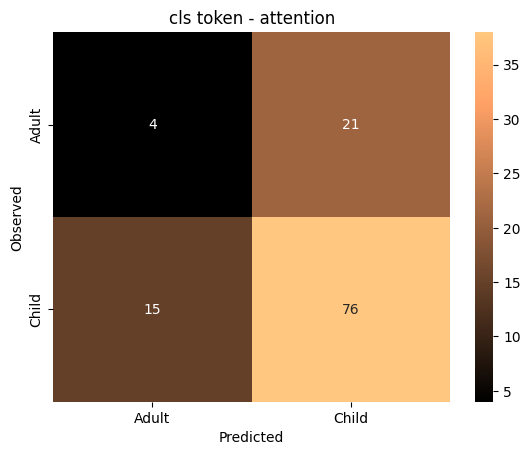

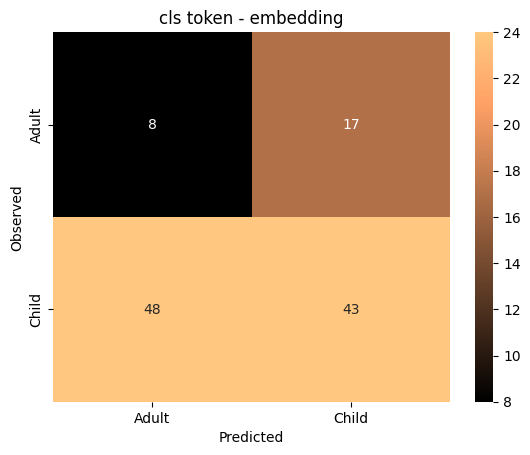

In [5]:
features = load_from_disk("../outputs/development_fmri_brainlm_a424_111M.arrow")
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)

plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc, y_ageclass)
plt.figure()
plt.title("cls token - attention")
pca_svc(1, cls_token, y_ageclass)
plt.figure()
plt.title("cls token - embedding")
pca_svc(1, np.array(features['embedding']).squeeze(), y_ageclass)

Overall Accuracy: 0.9224137931034483
              precision    recall  f1-score   support

       adult       0.81      0.84      0.82        25
       child       0.96      0.95      0.95        91

    accuracy                           0.92       116
   macro avg       0.88      0.89      0.89       116
weighted avg       0.92      0.92      0.92       116

Overall Accuracy: 0.3017241379310345
              precision    recall  f1-score   support

       adult       0.23      0.96      0.37        25
       child       0.92      0.12      0.21        91

    accuracy                           0.30       116
   macro avg       0.57      0.54      0.29       116
weighted avg       0.77      0.30      0.25       116

Overall Accuracy: 0.6551724137931034
              precision    recall  f1-score   support

       adult       0.29      0.40      0.33        25
       child       0.81      0.73      0.77        91

    accuracy                           0.66       116
   macro avg     

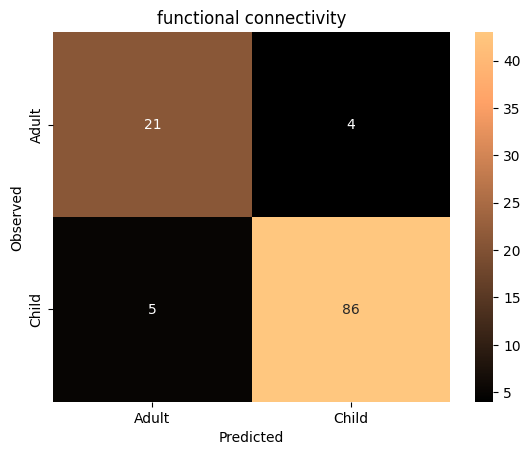

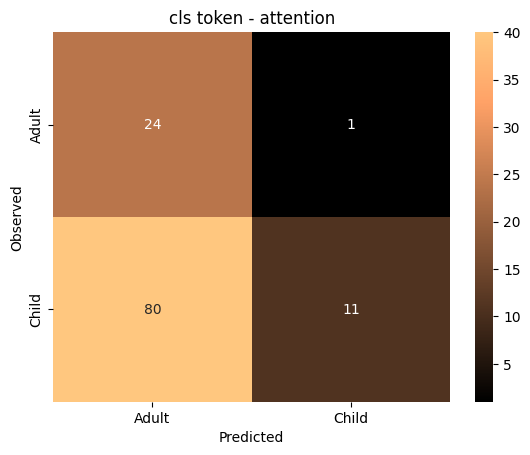

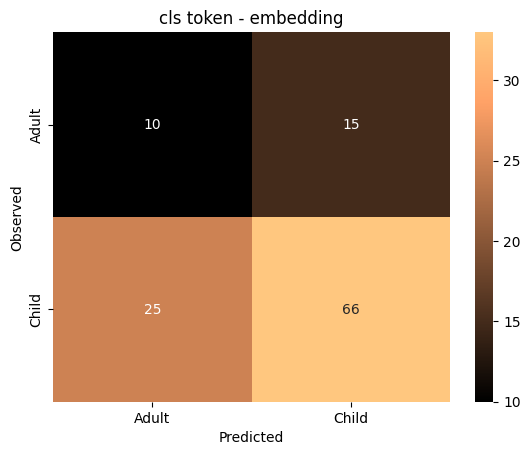

In [6]:
features = load_from_disk("../outputs/development_fmri_brainlm_a424_650M.arrow")
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)

plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc, y_ageclass)
plt.figure()
plt.title("cls token - attention")
pca_svc(1, cls_token, y_ageclass)
plt.figure()
plt.title("cls token - embedding")
pca_svc(1, np.array(features['embedding']).squeeze(), y_ageclass)